### Dataset
Download the MNIST dataset into local memory; this is used to implement the custom Dataset and DataLoader classes.

In [1]:
!rm -rf mnist_data
!mkdir mnist_data
%cd mnist_data

!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!curl -O http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

!gunzip *.gz
%cd ..

/Users/akshatgupta/Desktop/IIITD/SEM_6/DL/DL-Assignments/Assignment1/mnist_data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9680k  100 9680k    0     0  5805k      0  0:00:01  0:00:01 --:--:-- 5803k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28881  100 28881    0     0  27221      0  0:00:01  0:00:01 --:--:-- 27246
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1610k  100 1610k    0     0   757k      0  0:00:02  0:00:02 --:--:--  758k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4542  100  4542    0     0  11523      0 --:--

### Transform 
This is the Transform function used for the custom DataLoader class.

In [2]:
import torch

def tensor_transform(data):
    return torch.from_numpy(data).to(torch.float32).div(255)

### CustomDataSet Class
This is the implementation of the custom Dataset class that returns a dataset object.

In [3]:
import os, struct
import numpy as np


class CustomDataset:
    def __init__(self,root,train=True):
        """
        Args:
            root (str): path to the directory of the dataset
            train (bool, default=True): if True return training data, else return testing data
        """
        self.root = root
        self.train = train

        self.data_name = ('train-images-idx3-ubyte' if train else 't10k-images-idx3-ubyte')
        self.labels_name = ('train-labels-idx1-ubyte' if train else 't10k-labels-idx1-ubyte')
        self.data, self.labels = self.load_data()


    def load_data(self):
        data_path = os.path.join(self.root, self.data_name)
        labels_path = os.path.join(self.root, self.labels_name)

        with open(data_path, 'rb') as f:
            _, _, rows, cols = struct.unpack('>IIII', f.read(16))
            data = np.frombuffer(f.read(), dtype=np.uint8)
            data = data.reshape(-1, 1, rows, cols)
        with open(labels_path, 'rb') as f:
            _, _ = struct.unpack('>II', f.read(8))
            labels = np.frombuffer(f.read(), dtype=np.uint8)

        return data, labels


    def __len__(self):
        return len(self.data)


    def __getitem__(self,index):
        img, target = list(self.data[index]), int(self.labels[index])
        return img, target

### CustomDataLoader Class
This is the implementation of the custom DataLoader class that loads the MNIST dataset batch-wise as a dictionary with "data" indicating the image data, and "label" indicating the label of each corresponding sample.

In [4]:
class CustomDataLoader:
    def __init__(self,dataset,batch_size=64,shuffle=False,transform=None):
        """
        Args:
            dataset (obj): Dataset object that will be loaded into the stream; must implement __getitem__ and __len__ functions
            batch_size (int, default=64): batch size
            shuffle (bool, default=False): if True shuffles the data before loading into stream
            transform (callable, default=None): transform function to apply to data
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.transform = transform
        self.num_samples = len(dataset)
        self.num_batches = (self.num_samples + batch_size - 1) // batch_size

    def __iter__(self):
        if self.shuffle:
            indices = torch.randperm(self.num_samples)
        else:
            indices = torch.arange(self.num_samples)

        for i in range(0, self.num_samples, self.batch_size):
            batch_indices = indices[i:min(self.num_samples,i+self.batch_size)]
            batch = [self.dataset[index] for index in batch_indices]
            batch = tuple(zip(*batch))
            data, label = batch

            if self.transform is not None:
                data = self.transform(np.array(data))

            yield {'data':data,'label':label}

    def __len__(self):
        return self.num_batches

In [5]:
traindata = CustomDataset(
    root="./mnist_data/",
    train=True
)
traindata,valdata = torch.utils.data.random_split(traindata,[50000,10000])
testdata = CustomDataset(
    root="./mnist_data/",
    train=False
)

### Dataset using ```torch.utils.data.Dataset```
This class loads the MNIST dataset using the implementation that PyTorch provides.

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


class MNISTDataset(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.MNIST(root=root, train=True, transform=transform, download=True)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return {'data': image, 'label': label}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [7]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x / 255.0)])
mnist_data = MNISTDataset(root="./mnist_data/",transform=transform)

100%|██████████| 9912422/9912422 [00:02<00:00, 3666278.77it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 3426461.51it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:01<00:00, 1196759.32it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10917208.46it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



### Performance Comparison of DataLoaders
The following blocks of code compare the performance of the CustomDataLoader and the torch.utils.data.DataLoader objects against different batch sizes.

The graph indicates that the CustomDataLoader loads data faster at smaller batch sizes, but is out-performed at larger batch sizes. The mean performance time indicates the CustomDataLoader loads data faster than the torch.utils.data.DataLoader object and is thus used for all further tasks.

In [8]:
import time

def measure_dataloader_time(dataloader):
    start_time = time.time()
    for batch in dataloader:
        data,labels = batch
        assert True
    end_time = time.time()
    return end_time - start_time

In [9]:
batch_sizes = [128,256,512,1024]

dataloader_1_times = []
for batch_size in batch_sizes:
    dataloader_1 = DataLoader(dataset=traindata, batch_size=batch_size, shuffle=True)
    time_taken = measure_dataloader_time(dataloader_1)
    dataloader_1_times.append(time_taken)

dataloader_2_times = []
for batch_size in batch_sizes:
    dataloader_2 = CustomDataLoader(dataset=traindata,batch_size=batch_size,shuffle=True,transform=tensor_transform)
    time_taken = measure_dataloader_time(dataloader_2)
    dataloader_2_times.append(time_taken)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:183: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


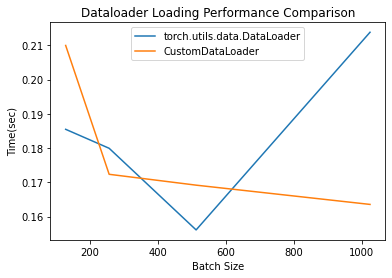

In [10]:
import matplotlib.pyplot as plt

plt.plot(batch_sizes, dataloader_1_times, label='torch.utils.data.DataLoader')
plt.plot(batch_sizes, dataloader_2_times, label='CustomDataLoader')
plt.xlabel('Batch Size')
plt.ylabel('Time(sec)')
plt.title('Dataloader Loading Performance Comparison')
plt.legend()
plt.show()

In [11]:
dataloader_1_times

[0.18546700477600098,
 0.1799299716949463,
 0.15610909461975098,
 0.21379470825195312]

In [12]:
dataloader_2_times

[0.20993995666503906,
 0.17234110832214355,
 0.16917204856872559,
 0.16354990005493164]

In [13]:
np.mean(dataloader_1_times)

0.18382519483566284

In [14]:
np.mean(dataloader_2_times)

0.17875075340270996

### Feed-Forward NN
This is the implementation of the Feed-Forward Neural Network using the PyTorch library functions and classes.

In [15]:
class FeedForwardNN(torch.nn.Module):
    def __init__(self,input_size,hidden_sizes,num_classes):
        super(FeedForwardNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = torch.nn.ReLU(inplace=True)

        self.fc2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = torch.nn.ReLU(inplace=True)

        self.fc3 = torch.nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = torch.nn.ReLU(inplace=True)

        self.fc4 = torch.nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.relu4 = torch.nn.ReLU(inplace=True)

        self.fc_out = torch.nn.Linear(hidden_sizes[3], num_classes)
        self.softmax = torch.nn.LogSoftmax(dim=1)

    
    def forward(self,x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.relu4(self.fc4(x))
        x = self.softmax(self.fc_out(x))

        return x

In [16]:
model = FeedForwardNN(
    input_size=28*28,
    hidden_sizes=[512,128,64,32],
    num_classes=10
)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.0003)

In [17]:
mps_device = torch.device('mps')
model.to(mps_device)

FeedForwardNN(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU(inplace=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (relu2): ReLU(inplace=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU(inplace=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (relu4): ReLU(inplace=True)
  (fc_out): Linear(in_features=32, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [18]:
trainloader = DataLoader(
    traindata,
    batch_size=128,
    shuffle=True
)
valloader = DataLoader(
    valdata,
    batch_size=128,
    shuffle=True
)
testloader = DataLoader(
    testdata,
    batch_size=128,
    shuffle=True
)

In [19]:
train_loss,test_loss,val_loss,train_acc,test_acc,val_acc = [],[],[],[],[],[]
n_epochs = 60

for epoch in range(n_epochs):
    model.train(mode=True)
    correct = 0
    n_samples = 0
    total_loss = 0

    for idx,batch in enumerate(trainloader):
        optimizer.zero_grad()
        data,labels = batch
        data = data[0].to(mps_device)
        labels = labels.to(mps_device)

        inputs = data.view(data.size(0),-1).float()
        outputs = model(inputs)
        l = loss(outputs,labels)
        l.backward()
        optimizer.step()

        _,pred = torch.max(outputs,1)
        correct += (pred==labels).sum().item()
        n_samples += labels.size(0)
        total_loss += l.cpu().item()

    avg_train_l = total_loss/len(trainloader)
    train_a = correct/n_samples

    train_loss.append(avg_train_l)
    train_acc.append(train_a)


    model.train(mode=False)
    correct = 0
    n_samples_test = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(testloader):
            testsamples,testlabels = batch
            testsamples = testsamples[0].to(mps_device)
            testlabels = testlabels.to(mps_device)

            inputs = testsamples.view(testsamples.size(0),-1).float()
            testoutputs = model(inputs)
            l = loss(testoutputs,testlabels)

            _,pred = torch.max(testoutputs,1)
            correct += (pred==testlabels).sum().item()
            n_samples_test += len(testlabels)
            total_loss += l.cpu().item()

    avg_test_l = total_loss/len(testloader)
    test_a = correct/n_samples_test

    test_loss.append(avg_test_l)
    test_acc.append(test_a)


    model.train(mode=False)
    correct = 0
    n_samples_val = 0
    total_loss = 0

    with torch.no_grad():
        for idx,batch in enumerate(valloader):
            valsamples,vallabels = batch
            valsamples = valsamples[0].to(mps_device)
            vallabels = vallabels.to(mps_device)

            inputs = valsamples.view(valsamples.size(0),-1).float()
            valoutputs = model(inputs)
            l = loss(valoutputs,vallabels)

            _,pred = torch.max(valoutputs,1)
            correct += (pred==vallabels).sum().item()
            n_samples_val += len(vallabels)
            total_loss += l.cpu().item()

    avg_val_l = total_loss/len(valloader)
    val_a = correct/n_samples_val

    val_loss.append(avg_val_l)
    val_acc.append(val_a)


    print(f"Epoch {epoch+1}/{n_epochs}:\nTrain Loss: {avg_train_l}, Train Accuracy: {train_a}\nVal Loss: {avg_val_l}, Val Accuracy: {val_a}\n")
    

Epoch 1/60:
Train Loss: 1.3889150425906072, Train Accuracy: 0.53706
Val Loss: 0.7975260306008255, Val Accuracy: 0.7809

Epoch 2/60:
Train Loss: 0.6094376530183856, Train Accuracy: 0.83212
Val Loss: 0.5156980571867544, Val Accuracy: 0.8577

Epoch 3/60:
Train Loss: 0.4408928490508243, Train Accuracy: 0.87652
Val Loss: 0.4189725480502165, Val Accuracy: 0.8859

Epoch 4/60:
Train Loss: 0.36579835811234496, Train Accuracy: 0.89612
Val Loss: 0.3653663853301278, Val Accuracy: 0.8971

Epoch 5/60:
Train Loss: 0.32183140992660964, Train Accuracy: 0.90828
Val Loss: 0.3305152449049527, Val Accuracy: 0.9073

Epoch 6/60:
Train Loss: 0.2917901395684313, Train Accuracy: 0.91664
Val Loss: 0.3066272794068614, Val Accuracy: 0.912

Epoch 7/60:
Train Loss: 0.2694482442058261, Train Accuracy: 0.92264
Val Loss: 0.2842471671255329, Val Accuracy: 0.9176

Epoch 8/60:
Train Loss: 0.2520042215200031, Train Accuracy: 0.92778
Val Loss: 0.27001149763789356, Val Accuracy: 0.9223

Epoch 9/60:
Train Loss: 0.237793455114

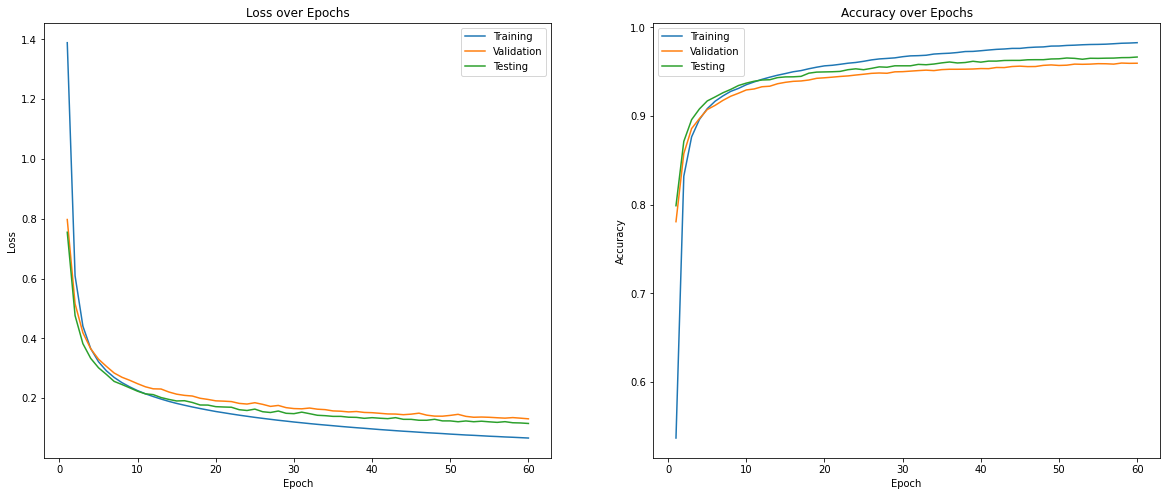

In [22]:
plt.figure(figsize=(20, 8))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_loss, label='Training')
plt.plot(range(1, n_epochs + 1), val_loss, label='Validation')
plt.plot(range(1, n_epochs + 1), test_loss, label='Testing')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_acc, label='Training')
plt.plot(range(1, n_epochs + 1), val_acc, label='Validation')
plt.plot(range(1, n_epochs + 1), test_acc, label='Testing')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plt.tight_layout()
plt.show()